In [1]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install d2l

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install py7zr

Note: you may need to restart the kernel to use updated packages.


In [7]:
# import urllib.request
# URL = "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/3649/46718/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1711022725&Signature=BBF%2F5tTn0gKyBSh6i%2FvcQXIGdXxmKlOBNRIsB9yPy%2FytkiMbM4NaXfFnV0sxL%2Fbz%2FJ3IDEH8J5VZ13HYMQVaZg04wdnKfLPOR85Qnx5l84Lur9bDYonWYO6RLjJnnc28kioSmn32eck%2BFkbke9zge7aV8KbBKa9gdlu0n%2Fc7KolqGbEAzWzJemAUB8bYOzR%2B1eWjIUkJSZI5Ir4Upd2xlxDQ3WlGkbRO%2FtxlP6%2FfctGSC6srQynsptCpFPu25i5qgY9qp1tSWrEYz8a0uDI75Y9iNCQDyBr5Dsem2PZROVCjqbCKOd3ZoW6YkNvFjKUYm%2BRky0TqVJHtg1a5nY495g%3D%3D&response-content-disposition=attachment%3B+filename%3Dcifar-10.zip"
# filename, headers = urllib.request.urlretrieve(URL, filename="cifar-10.zip")

In [8]:
# import zipfile

# zip_path = "cifar-10.zip"  # ZIP文件路径
# output_dir = "data/cifar-10"  # 解压输出目录

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(output_dir)

# print("解压完成！")

In [9]:
# import py7zr

# archive_path = "data/cifar-10/test.7z"  # 压缩文件路径
# output_dir = "data/cifar-10"  # 解压输出目录

# with py7zr.SevenZipFile(archive_path, mode='r') as z:
#     z.extractall(path=output_dir)

# print("解压完成！")

In [10]:
# archive_path = "data/cifar-10/train.7z"  # 压缩文件路径
# output_dir = "data/cifar-10"  # 解压输出目录

# with py7zr.SevenZipFile(archive_path, mode='r') as z:
#     z.extractall(path=output_dir)

# print("解压完成！")

In [11]:
# #@save
# d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
#                                 '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# 如果使用完整的Kaggle竞赛的数据集，设置demo为False
demo = False

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = 'data/cifar-10/'

In [12]:
#@save
def read_csv_labels(fname):
    """读取fname来给标签字典返回一个文件名"""
    with open(fname, 'r') as f:
        # 跳过文件头行(列名)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# 训练样本 :', len(labels))
print('# 类别 :', len(set(labels.values())))

# 训练样本 : 50000
# 类别 : 10


In [13]:
#@save
def copyfile(filename, target_dir):
    """将文件复制到目标目录"""
    # 创建目标目录（如果不存在）
    os.makedirs(target_dir, exist_ok=True)
    # 复制文件到目标目录
    shutil.copy(filename, target_dir)

#@save
def reorg_train_valid(data_dir, labels, valid_ratio):
    """将验证集从原始的训练集中拆分出来"""
    # 统计训练数据集中每个类别的样本数，并获取样本最少的类别中的样本数
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # 计算验证集中每个类别的样本数
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    # 用于记录每个类别已经分配到验证集的样本数
    label_count = {}
    # 遍历训练数据目录中的每个文件
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        # 获取文件对应的标签
        label = labels[train_file.split('.')[0]]
        # 获取文件的完整路径
        fname = os.path.join(data_dir, 'train', train_file)
        # 将文件复制到 'train_valid' 子目录中
        copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train_valid', label))
        # 如果该类别的验证集样本数未达到指定数量，则将文件复制到 'valid' 子目录
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'valid', label))
            # 更新该类别的验证集样本数
            label_count[label] = label_count.get(label, 0) + 1
        else:
            # 否则，将文件复制到 'train' 子目录
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train', label))
    # 返回每个类别的验证集样本数
    return n_valid_per_label

In [14]:
#@save
def reorg_test(data_dir):
    """在预测期间整理测试集，以方便读取"""
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test',
                              'unknown'))

In [15]:
# 定义重新组织 CIFAR-10 数据集的函数
def reorg_cifar10_data(data_dir, valid_ratio):
    # 读取训练数据集的标签
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    # 调用函数将训练集拆分为训练集和验证集
    reorg_train_valid(data_dir, labels, valid_ratio)
    # 调用函数组织测试数据集
    reorg_test(data_dir)

In [16]:
# 设置批量大小
batch_size = 32 if demo else 128
# 设置验证集比例
valid_ratio = 0.1
# 调用函数重新组织 CIFAR-10 数据集
reorg_cifar10_data(data_dir, valid_ratio)

In [17]:
transform_train = torchvision.transforms.Compose([
    # 在高度和宽度上将图像放大到40像素的正方形
    torchvision.transforms.Resize(40),
    # 随机裁剪出一个高度和宽度均为40像素的正方形图像，
    # 生成一个面积为原始图像面积0.64～1倍的小正方形，
    # 然后将其缩放为高度和宽度均为32像素的正方形
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                   ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

In [18]:
# 定义测试数据的预处理变换
transform_test = torchvision.transforms.Compose([
    # 将图像转换为Tensor
    torchvision.transforms.ToTensor(),
    # 使用CIFAR-10数据集的均值和标准差对图像进行标准化
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])
])

In [19]:
# 加载训练集和训练验证集数据，并应用预处理变换
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

# 加载验证集和测试集数据，并应用预处理变换
valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

In [20]:
# 创建训练集和训练验证集的数据加载器
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

# 创建验证集的数据加载器，不进行随机打乱
valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

# 创建测试集的数据加载器，不进行随机打乱，也不丢弃最后一个不完整批次
test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

In [21]:
##定义resnet18神经网络
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes, 3)
    return net

loss = nn.CrossEntropyLoss(reduction="none")

In [22]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    # 初始化优化器，使用随机梯度下降法 (SGD) 优化模型参数，设置学习率 lr, 动量 momentum 和权重衰减 wd
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    # 初始化学习率调度器，每 lr_period 个周期衰减学习率 lr_decay
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    # 获取训练数据迭代器的批次数量，并初始化计时器
    num_batches, timer = len(train_iter), d2l.Timer()
    # 定义训练过程中的可视化图例
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    # 初始化动画绘制器，用于绘制训练过程中损失和准确率的变化
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend)
    # 使用数据并行将模型分布到多个设备上
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    
    # 训练模型
    for epoch in range(num_epochs):
        # 设置模型为训练模式
        net.train()
        # 初始化累加器，用于统计训练损失和准确率
        metric = d2l.Accumulator(3)
        # 遍历训练数据
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            # 训练一个批次的数据，并计算损失和准确率
            l, acc = d2l.train_batch_ch13(net, features, labels, loss, trainer, devices)
            # 累加损失和准确率，以及样本数
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            # 定期更新动画绘制器
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2], None))
        # 如果存在验证集，则在每个 epoch 后计算验证集准确率并更新动画绘制器
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        # 更新学习率
        scheduler.step()
    
    # 输出训练损失和准确率，以及每秒处理的样本数
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(devices)}')


train loss 0.006, train acc 0.998, valid acc 0.890
1374.2 examples/sec on [device(type='cuda', index=0)]


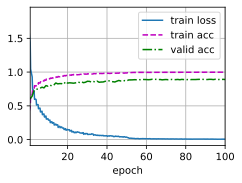

In [23]:
## 设置参数，开始训练
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 100, 1e-4, 5e-4
lr_period, lr_decay, net = 50, 0.1, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

In [24]:
## 保存模型
model_path = 'cifar10_model_state_dict.pth'
torch.save(net.state_dict(), model_path)
print(f'Model saved to {model_path}')

Model saved to cifar10_model_state_dict.pth


train loss 0.006, train acc 0.998
1372.6 examples/sec on [device(type='cuda', index=0)]


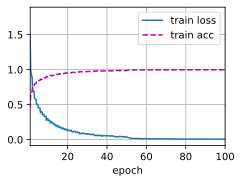

In [25]:
# 初始化模型并创建一个空列表用于存储预测结果
net, preds = get_net(), []

# 使用包含训练和验证数据的迭代器训练模型
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)

# 对测试集进行预测
for X, _ in test_iter:
    # 将输入数据移动到第一个GPU设备上并进行前向传播
    y_hat = net(X.to(devices[0]))
    # 获取预测结果的类别索引，并转换为numpy数组后添加到预测结果列表中
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())

# 创建测试集样本的ID列表，ID从1开始
sorted_ids = list(range(1, len(test_ds) + 1))
# 对ID列表按字符串进行排序（按数字顺序）
sorted_ids.sort(key=lambda x: str(x))

# 创建一个包含ID和预测标签的DataFrame
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
# 将预测的类别索引转换为实际的类别名称
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
# 将DataFrame保存为CSV文件，用于提交结果
df.to_csv('submission.csv', index=False)
